In [51]:
%%time
import sagemaker
from sagemaker import get_execution_role

role = get_execution_role()
print(role)
sess = sagemaker.Session()

arn:aws:iam::852382942743:role/service-role/AmazonSageMaker-ExecutionRole-20200713T184760
CPU times: user 137 ms, sys: 18.6 ms, total: 155 ms
Wall time: 204 ms


In [52]:

from sagemaker.amazon.amazon_estimator import get_image_uri

training_image = get_image_uri(sess.boto_region_name, 'object-detection', repo_version="latest")
print (training_image)

The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: latest.


811284229777.dkr.ecr.us-east-1.amazonaws.com/object-detection:1


In [53]:
bucket = sess.default_bucket()
prefix = 'Clover'

In [54]:
%%time

train_channel = prefix + '/train'
validation_channel = prefix + '/validation'
train_annotation_channel = prefix + '/train_annotation'
validation_annotation_channel = prefix + '/validation_annotation'

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 10 µs


In [55]:
s3_train_data = 's3://{}/{}'.format(bucket, train_channel)
s3_validation_data = 's3://{}/{}'.format(bucket, validation_channel)
s3_train_annotation = 's3://{}/{}'.format(bucket, train_annotation_channel)
s3_validation_annotation = 's3://{}/{}'.format(bucket, validation_annotation_channel)

In [56]:
s3_output_location = 's3://{}/{}/output'.format(bucket, prefix)

In [57]:

od_model = sagemaker.estimator.Estimator(training_image,
                                         role, 
                                         train_instance_count=1, 
                                         train_instance_type='ml.p3.2xlarge',
                                         train_volume_size = 50,
                                         train_max_run = 360000,
                                         input_mode = 'File',
                                         output_path=s3_output_location,
                                         sagemaker_session=sess)

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_max_run has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_volume_size has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [109]:
od_model.set_hyperparameters(base_network='resnet-50',
                             use_pretrained_model=0,
                             num_classes=2,
                             mini_batch_size=16,
                             epochs=30,
                             learning_rate=0.001,
                             lr_scheduler_step='10',
                             lr_scheduler_factor=0.1,
                             optimizer='sgd',
                             momentum=0.9,
                             weight_decay=0.0005,
                             overlap_threshold=0.5,
                             nms_threshold=0.45,
                             image_shape=512,
                             label_width=1070,
                             num_training_samples=15935) 

In [110]:
train_data = sagemaker.session.s3_input(s3_train_data, distribution='FullyReplicated', 
                        content_type='image/jpeg', s3_data_type='S3Prefix')
validation_data = sagemaker.session.s3_input(s3_validation_data, distribution='FullyReplicated', 
                             content_type='image/jpeg', s3_data_type='S3Prefix')
train_annotation = sagemaker.session.s3_input(s3_train_annotation, distribution='FullyReplicated', 
                             content_type='image/jpeg', s3_data_type='S3Prefix')
validation_annotation = sagemaker.session.s3_input(s3_validation_annotation, distribution='FullyReplicated', 
                             content_type='image/jpeg', s3_data_type='S3Prefix')

data_channels = {'train': train_data, 'validation': validation_data, 
                 'train_annotation': train_annotation, 'validation_annotation':validation_annotation}

The class sagemaker.session.s3_input has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The class sagemaker.session.s3_input has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The class sagemaker.session.s3_input has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The class sagemaker.session.s3_input has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [111]:
od_model.fit(inputs=data_channels, logs=True)

2021-01-26 22:36:41 Starting - Starting the training job...
2021-01-26 22:37:07 Starting - Launching requested ML instancesProfilerReport-1611700601: InProgress
.........
2021-01-26 22:38:28 Starting - Preparing the instances for training......
2021-01-26 22:39:35 Downloading - Downloading input data......
2021-01-26 22:40:43 Training - Downloading the training image...
2021-01-26 22:41:11 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
[01/26/2021 22:41:10 INFO 139837478897472] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'label_width': u'350', u'early_stopping_min_epochs': u'10', u'epochs': u'30', u'overlap_threshold': u'0.5', u'lr_scheduler_factor': u'0.1', u'_num_kv_servers': u'auto', u'weight_decay': u'0.0005', u'mini_batch_size': u'32', u'use_pretrained_model': u'0', u'freeze_layer_pattern': u'', u'lr_scheduler_step': u'', u'early_stopping': u'False',

KeyboardInterrupt: 

In [108]:
object_detector = od_model.deploy(initial_instance_count = 1,
                                 instance_type = 'ml.m4.xlarge')

----

KeyboardInterrupt: 

In [100]:
file_name = "clover_test.jpg"
with open(file_name, 'rb') as image:
    f = image.read()
    b = bytearray(f)
    ne = open('n.txt','wb')
    ne.write(b)

In [101]:
import json

#object_detector.content_type = 'image/jpeg'
results = object_detector.predict(b, initial_args={'ContentType':'image/jpeg'})
detections = json.loads(results)
print (detections)

{'prediction': [[1.0, 0.7834888696670532, 0.31245094537734985, 0.21592575311660767, 0.6692080497741699, 0.7081417441368103], [1.0, 0.3536728322505951, 0.6551693081855774, 0.6202284693717957, 0.998455822467804, 0.9417186379432678], [0.0, 0.2627456486225128, 0.6934497356414795, 0.5314772129058838, 0.9796696901321411, 0.8350403308868408], [0.0, 0.2167561650276184, 0.6616604328155518, 0.6308915019035339, 1.0, 0.9308844208717346], [0.0, 0.21584363281726837, 0.37678372859954834, 0.0, 0.5726275444030762, 0.20006421208381653], [0.0, 0.1925215721130371, 0.04287920892238617, 0.8107835054397583, 0.2523980736732483, 0.989197850227356], [0.0, 0.18943524360656738, 0.07027255743741989, 0.0, 0.26701709628105164, 0.1996896117925644], [1.0, 0.18569861352443695, 0.1771431565284729, 0.40554141998291016, 0.5992453098297119, 0.8601335287094116], [1.0, 0.18437910079956055, 0.18594703078269958, 0.1122494637966156, 0.5677670240402222, 0.6524671316146851], [0.0, 0.158467099070549, 0.08029944449663162, 0.0711573

In [102]:
def visualize_detection(img_file, dets, classes=[], thresh=0.6):
        """
        visualize detections in one image
        Parameters:
        ----------
        img : numpy.array
            image, in bgr format
        dets : numpy.array
            ssd detections, numpy.array([[id, score, x1, y1, x2, y2]...])
            each row is one object
        classes : tuple or list of str
            class names
        thresh : float
            score threshold
        """
        import random
        import matplotlib.pyplot as plt
        import matplotlib.image as mpimg

        img=mpimg.imread(img_file)
        plt.imshow(img)
        height = img.shape[0]
        width = img.shape[1]
        colors = dict()
        for det in dets:
            (klass, score, x0, y0, x1, y1) = det
            if score < thresh:
                continue
            cls_id = int(klass)
            if cls_id not in colors:
                colors[cls_id] = (random.random(), random.random(), random.random())
            xmin = int(x0 * width)
            ymin = int(y0 * height)
            xmax = int(x1 * width)
            ymax = int(y1 * height)
            rect = plt.Rectangle((xmin, ymin), xmax - xmin,
                                 ymax - ymin, fill=False,
                                 edgecolor=colors[cls_id],
                                 linewidth=1.5)
            plt.gca().add_patch(rect)
            class_name = str(cls_id)
            if classes and len(classes) > cls_id:
                class_name = classes[cls_id]
            plt.gca().text(xmin, ymin - 2,
                            '{:s} {:.3f}'.format(class_name, score),
                            bbox=dict(facecolor=colors[cls_id], alpha=0.5),
                                    fontsize=12, color='white')
        plt.show()

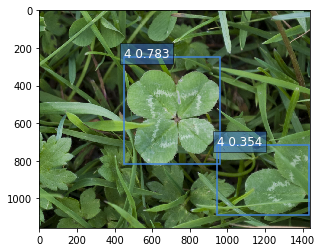

In [103]:

object_categories = ['3','4']
# Setting a threshold 0.20 will only plot detection results that have a confidence score greater than 0.20.
threshold = 0.3

# Visualize the detections.
visualize_detection(file_name, detections['prediction'], object_categories, threshold)

In [112]:
sagemaker.Session().delete_endpoint(object_detector.endpoint)

The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


ClientError: An error occurred (ValidationException) when calling the DeleteEndpoint operation: Could not find endpoint "arn:aws:sagemaker:us-east-1:852382942743:endpoint/object-detection-2021-01-26-18-59-12-901".